In [37]:
import pandas as pd
from  wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from itertools import combinations
from sklearn.metrics.pairwise import  cosine_similarity

In [38]:
use_large = False
if use_large:
    movies = pd.read_csv("../../../DataSets/ml-latest/movies.csv")
    ratings = pd.read_csv("../../../DataSets/ml-latest/ratings.csv")
    tags = pd.read_csv("../../../DataSets/ml-latest/tags.csv")
    links = pd.read_csv("../../../DataSets/ml-latest/links.csv")
    g_tags = pd.read_csv("../../../DataSets/ml-latest/genome-tags.csv")
    g_scores = pd.read_csv("../../../DataSets/ml-latest/genome-scores.csv")
else :
    movies = pd.read_csv("../../../DataSets/ml-latest-small/movies.csv")
    ratings = pd.read_csv("../../../DataSets/ml-latest-small/ratings.csv")
    tags = pd.read_csv("../../../DataSets/ml-latest-small/tags.csv")
    links = pd.read_csv("../../../DataSets/ml-latest-small/links.csv")

In [39]:
movies['year'] = movies['title'].str.extract('.*\((.*)\).*',expand = False)
movies['year'] = movies['year'].str.extract('(\d+)', expand=False)
movies.dropna(inplace=True)
movies['year'] = movies['year'].astype(int)
movies['title'] = movies['title'].replace(r'\([^)]*\)', '', regex=True).str.lower()
movies.head()

,movieId,title,genres,year
0,1,toy story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,jumanji,Adventure|Children|Fantasy,1995
2,3,grumpier old men,Comedy|Romance,1995
3,4,waiting to exhale,Comedy|Drama|Romance,1995
4,5,father of the bride part ii,Comedy,1995


In [40]:
final_df = movies
final_df["userid"] = ratings["userId"]
final_df["rating"] = ratings["rating"]
final_df["tag"] = tags["tag"]
# final_df["g_tag"] = g_tags["tag"]

In [41]:
final_df.dropna(inplace=True)
final_df.isna().sum()

movieId    0
title      0
genres     0
year       0
userid     0
rating     0
tag        0
dtype: int64

In [42]:
final_df = final_df.drop(["movieId"], axis=1)


In [43]:
final_df.head()

,title,genres,year,userid,rating,tag
0,toy story,Adventure|Animation|Children|Comedy|Fantasy,1995,1,4.0,funny
1,jumanji,Adventure|Children|Fantasy,1995,1,4.0,Highly quotable
2,grumpier old men,Comedy|Romance,1995,1,4.0,will ferrell
3,waiting to exhale,Comedy|Drama|Romance,1995,1,5.0,Boxing story
4,father of the bride part ii,Comedy,1995,1,5.0,MMA


In [44]:
final_df.shape

(3683, 6)

In [45]:
final_df.info();

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3683 entries, 0 to 3682
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   title   3683 non-null   object 
 1   genres  3683 non-null   object 
 2   year    3683 non-null   int32  
 3   userid  3683 non-null   int64  
 4   rating  3683 non-null   float64
 5   tag     3683 non-null   object 
dtypes: float64(1), int32(1), int64(1), object(3)
memory usage: 187.0+ KB


In [46]:
final_df[['title', 'rating']].sort_values('rating', ascending=False).head(10)

,title,rating
1841,virus,5.0
1467,child's play 2,5.0
3066,hiding out,5.0
3064,gardens of stone,5.0
1466,child's play,5.0
419,kalifornia,5.0
3057,cop,5.0
421,lassie,5.0
425,m. butterfly,5.0
409,"hudsucker proxy, the",5.0


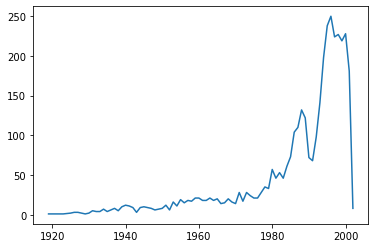

Max No.of Movies Relesed = 250
year = 1996


count     82.000000
mean      44.914634
std       66.165561
min        1.000000
25%        7.250000
50%       17.000000
75%       46.000000
max      250.000000
Name: title, dtype: float64

In [47]:
plt.plot(final_df.groupby('year').title.count())
plt.show()
a = final_df.groupby('year').title.count()
print('Max No.of Movies Relesed =', a.max())
for i in a.index:
    if a[i] == a.max():
        print('year =', i)
a.describe()


#### Content Based Filtering
There are two types of filtering in content based movie recommendation
1. Description Based - Based on textual description of the movie or the taglines/punchlines
2. Meta data based - Genre, Keywords etc <br />
As we only have metadata of the movies, we will work with Meta Data based filtering

#### Exploring Genre's

In [48]:
genre_popularity = (final_df.genres.str.split('|')
                      .explode()
                      .value_counts()
                      .sort_values(ascending=False))
genre_popularity.head(10)


Drama        1720
Comedy       1375
Thriller      688
Romance       669
Action        597
Adventure     446
Crime         411
Horror        351
Sci-Fi        324
Children      275
Name: genres, dtype: int64

(-0.5, 999.5, 399.5, -0.5)

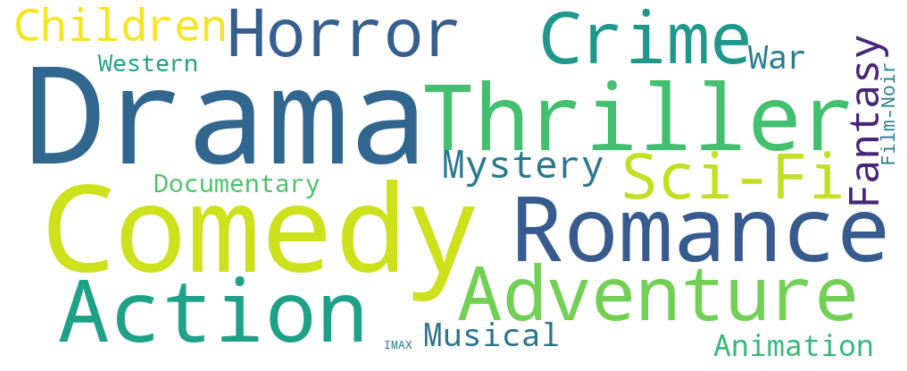

In [49]:
genre_wc = WordCloud(width=1000,height=400,background_color='white')
genre_wc.generate_from_frequencies(genre_popularity.to_dict())
plt.figure(figsize=(16, 8))
plt.imshow(genre_wc, interpolation="bilinear")
plt.axis('off')

In [50]:
tf = TfidfVectorizer(analyzer=lambda s: (c for i in range(1,4)
                     for c in combinations(s.split('|'), r=i)))
tfidf_matrix = tf.fit_transform(movies['genres'])
tfidf_matrix.shape


(3683, 538)

In [51]:
cosine_sim = cosine_similarity(tfidf_matrix)

In [52]:
indices = pd.Series(final_df.index, index=final_df['title']).drop_duplicates()

In [53]:
def recommend(title, cosine_sim=cosine_sim) :
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key = lambda x:x[1], reverse = True)
    # Top 15
    sim_scores = sim_scores[1:16]
    movie_indices = [i[0] for i in sim_scores]
    for i in movie_indices:
        pop = final_df.at[i, 'rating']
        if pop<5 or pop>10:
            movie_indices.remove(i)

    return final_df[["title", "rating"]].iloc[movie_indices]

In [54]:
final_df.head()
indices


title
toy story                          0
jumanji                            1
grumpier old men                   2
waiting to exhale                  3
father of the bride part ii        4
                                ... 
walk to remember, a             3678
beijing bicycle                 3679
escaflowne: the movie           3680
maelström                       3681
metropolis                      3682
Length: 3683, dtype: int64

In [55]:
var_v = indices.keys()
var_v = var_v[0]
print(var_v)
recommend(var_v)

toy story 


,title,rating
2355,toy story 2,2.0
3000,"emperor's new groove, the",2.5
1505,"black cauldron, the",3.0
2539,we're back! a dinosaur's story,3.0
3336,"land before time, the",4.5
1757,"bug's life, a",4.5
3194,shrek,4.5
